In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [205]:
n = 1000
T = 10000
var = 1
x = np.random.normal(0, sigma, (T, n))

In [303]:
C = np.dot(x.T, x) / T

### Eigen values of normally distributed random variables

In [207]:
w, v = np.linalg.eig(C)

In [208]:
w.sort()

### Marcenko-Pastur Probability distribution function

In [214]:
def mpPDF(var, q, pts = 20):
    lambdap = var * np.power(1 + 1./np.sqrt(q), 2)
    lambdan = var * np.power(1 - 1./np.sqrt(q), 2)
    x = np.linspace(lambdan, lambdap, pts)
    y = np.sqrt((lambdap - x) * (x - lambdan)) / (2 * np.pi * x * np.power(sigma,2)) * q
    return pd.Series(y, index = x)

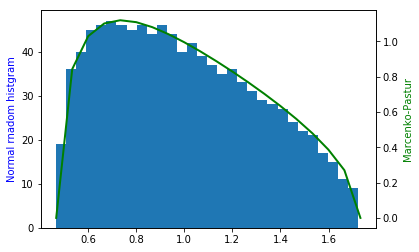

In [215]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist(w, bins=30)
ax2.plot(mpPDF(var, float(T)/ n), 'g-', lw = 2)
ax1.set_ylabel('Normal rnadom histgram', color='b')
ax2.set_ylabel('Marcenko-Pastur', color='g')

plt.show()

In [216]:
from sklearn.neighbors.kde import KernelDensity
# Why not use sklearn.decomposition.PCA?
def getPCA(matrix):
    # Return eigen values and principal components if matrix is covariance matrix 
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1]
    eVal, eVec = eVal[indices],eVec[:, indices]
    eVal = np.diagflat(eVal)
    return eVal, eVec

def fitKDE(obs, bWidth = 0.25, kernel = 'gaussian', x = None):
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    kde = KernelDensity(kernel= kernel, bandwidth=bWidth).fit(obs)
    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logProb = kde.score_samples(x)
    pdf = pd.Series(np.exp(logProb), index = x.flatten())
    return pdf

In [218]:
x = np.random.normal(size=(T,n))
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))
pdf0 = mpPDF(1., float(T)/n,100)
pdf1 = fitKDE(np.diag(eVal0), bWidth=0.01)

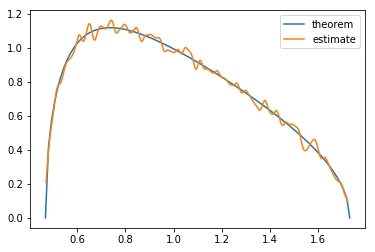

In [219]:
plt.plot(pdf0, label = 'theorem')
plt.plot(pdf1, label = 'estimate')
plt.legend()
plt.show()

In [229]:
def getRndConv(nCols, nFacts):
    w = np.random.normal(size = (nCols, nFacts))
    cov = np.dot(w, w.T)
    cov += np.diag(np.random.uniform(size = nCols))
    return cov

def cov2corr(cov):
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1], corr[corr > 1] = -1, 1
    return corr

In [246]:
alpha, nCols, nFact = 0.995, 1000, 100
q = int(nCols / nFact)
cov = np.cov(np.random.normal(size = (nCols * q, nCols)), rowvar=0)
cov = alpha * cov + (1 - alpha) * getRndConv(nCols, nFact)
corr0 = cov2corr(cov)
eVal0, eVec = getPCA(corr0)

In [247]:
from scipy.optimize import minimize

def errPDFs(var, eVal, q, bWidth, pts = 100):
    pdf0 = mpPDF(var, q, pts)
    pdf1 = fitKDE(eVal, bWidth,x = pdf0.index.values)
    sse = np.sum((pdf1 - pdf0)**2)
    return sse

def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), 
                   0.5, 
                   args=(eVal, q, bWidth),
                   bounds=((1E-5, 1-1E-5),))
    if out['success']:
        var = out['x'][0]
    else:
        var = 1
    eMax = var * (1 + (1.0/q)**0.5)**2
    return eMax, var

In [248]:
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

In [264]:
print('nFacts:',nFacts0)
print('Estimated variance:',var0)

nFacts: 100
Estimated variance: 0.6931450025279021


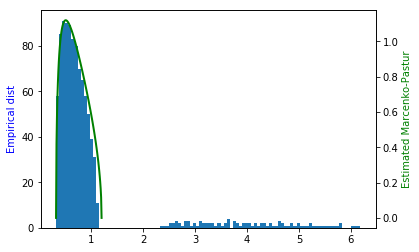

In [276]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist(np.diag(eVal0), bins=100, label = 'Emprical dist')
ax2.plot(mpPDF(var0, q, pts=100), 'g', lw = 2., label = 'Estimated Marcenko-Pastur')
ax1.set_ylabel('Empirical dist', color='b')
ax2.set_ylabel('Estimated Marcenko-Pastur', color='g')
plt.show()

### SNIPPET 2.5

In [556]:
def denoisedCorr(eVal, eVec, nFacts):
    '''denoising by constant residual eigen value
    '''
    eVal_ = np.diag(eVal).copy()
    eVal_[nFacts:] = eVal_[nFacts:].sum() / float(eVal_.shape[0] - nFacts)
    eVal_ = np.diag(eVal_)
    corrl = np.dot(eVec, eVal_).dot(eVec.T)
    corrl = cov2corr(corrl)
    return corrl

In [309]:
corrl = denoisedCorr(eVal0, eVec0, nFacts0)
eVal1, eVec1 = getPCA(corrl)

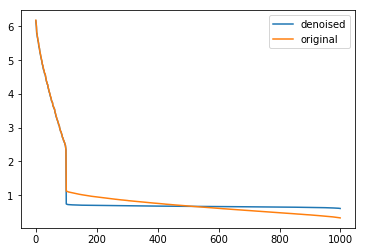

In [310]:
plt.plot(np.diag(eVal1), label = 'denoised')
plt.plot(np.diag(eVal0), label = 'original')
plt.legend()
plt.show()

### SNIPPET 2.6

In [557]:
def denoisedCorr2(eVal, eVec, nFacts, alpha = 0):
    '''denoising by targeted shrinkage
    '''
    eValL, eVecL = eVal[:nFacts, :nFacts], eVec[:, :nFacts]
    eValR, eVecR = eVal[nFacts:, nFacts:], eVec[:, nFacts:]
    corr0 = np.dot(eVecL, eValL).dot(eVecL.T)
    corr1 = np.dot(eVecR, eValR).dot(eVecR.T)
    corr2 = corr0 + alpha * corr1 + (1 - alpha) * np.diag(np.diag(corr1))
    return corr2

In [320]:
corr1 = denoisedCorr2(eVal0, eVec0, nFacts0, alpha = 0.5)
eVal1, eVec1 = getPCA(corr1)

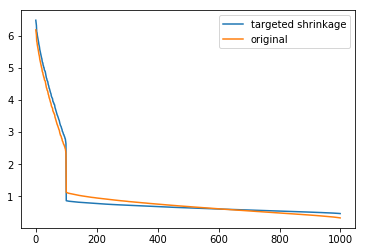

In [349]:
plt.plot(np.diag(eVal1), label = 'targeted shrinkage')
plt.plot(np.diag(eVal0), label = 'original')
plt.legend()
plt.show()

### SNIPPET 2.7

In [344]:
def corr2cov(corr, std):
    return corr * np.outer(std, std)

In [485]:
from scipy.linalg import block_diag
def formBlockMatrix(nBlocks, bSize, bCorr):
    block = np.ones((bSize, bSize)) * bCorr
    block[range(bSize), range(bSize)] = 1
    corr = block_diag(*([block]*nBlocks))
    return corr

def formTrueMatrix(nBlocks, bSize, bCorr):
    corr0 = formBlockMatrix(nBlocks, bSize, bCorr)
    corr0 = pd.DataFrame(corr0)
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0 = corr0[cols].loc[cols].copy(deep = True)
    std0 = np.random.uniform(0.05, 0.2, corr0.shape[0])
    cov0 = corr2cov(corr0, std0)
    mu0 = np.random.normal(std0, std0, cov0.shape[0]).reshape(-1, 1)
    return mu0, cov0

In [346]:
nBlocks, bSize, bCorr = 10, 50, 0.5
np.random.seed(0)
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)

### SNIPPET 2.8

In [347]:
from sklearn.covariance import LedoitWolf

def simCovMu(mu0, cov0, nObs, shrink=False):
    x = np.random.multivariate_normal(mu0.flatten(), cov0, size = nObs)
    mul = x.mean(axis = 0).reshape(-1, 1)
    if shrink:
        cov1 = LedoitWolf().fit(x).covariance_
    else:
        cov1 = np.cov(x, rowvar=0)
    return mul, cov1

### SNIPPET 2.9

In [348]:
def deNoiseCov(cov0, q, bWidth):
    corr0 = cov2corr(cov0)
    eVal0, eVec0 = getPCA(corr0)
    eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth)
    nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1 = denoisedCorr(eVal0, eVec0, nFacts0)
    cov1 = corr2cov(corr1, np.diag(cov0)**0.5)
    return cov1

### SNIPPET 2.10

In [361]:
def optPort(cov, mu = None):
    inv = np.linalg.inv(cov)
    ones = np.ones(shape = (inv.shape[0], 1))
    if mu is None:
        mu = ones
    w = np.dot(inv, mu)
    w /= np.dot(ones.T, w)
    return w

nObs, nTrials, bWidth, shrink, minVarPortf = 1000, 1000, 0.01, False, False
w1 = pd.DataFrame(columns=range(cov0.shape[0]),
                  index=range(nTrials),
                  dtype=float)
w1_d = w1.copy(deep = True)
np.random.seed(0)
for i in range(nTrials):
    mu1, cov1 = simCovMu(mu0, cov0, nObs, shrink=shrink)
    if minVarPortf:
        mu1 = None
    cov1_d = deNoiseCov(cov1, nObs*1./cov1.shape[1], bWidth)
    w1.loc[i] = optPort(cov1, mu1).flatten()
    w1_d.loc[i] = optPort(cov1_d, mu1).flatten()

### SNIPPET 2.11

In [362]:
w0 = optPort(cov0, None if minVarPortf else mu0)
w0 = np.repeat(w0.T, w1.shape[0], axis = 0)
rmsd = np.mean((w1 - w0).values.flatten()**2)**0.5
rmsd_d = np.mean((w1_d - w0).values.flatten()**2)**0.5
print('Not denoised:', rmsd)
print('Denoised    :', rmsd_d)

Not denoised: 0.6061080770562829
Denoised    : 0.014920587721394162


### JPY Bond Yield

In [363]:
path = r"https://www.mof.go.jp/english/jgbs/reference/interest_rate/historical/jgbcme_all.csv"
raw = pd.read_csv(path, header=1, index_col="Date")

In [588]:
columns = ['2Y', '5Y', '7Y', '10Y', '15Y', '20Y', '30Y', '40Y']

In [590]:
data = np.array(raw[columns][raw.index > '2016/6/1'], dtype = np.float64)

In [602]:
cov = np.cov(data.T)
corr0 = cov2corr(cov)
eVal, eVec = getPCA(cov)
denoised_cov = deNoiseCov(cov, 0.5, 0.01)
denoised_eVal, denoised_eVec = getPCA(denoised_cov)

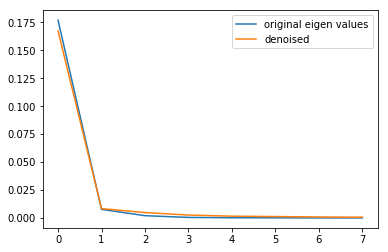

In [618]:
plt.plot(np.diag(eVal), label = 'original eigen values')
plt.plot(np.diag(denoised_eVal), label = 'denoised')
plt.legend()
plt.show()

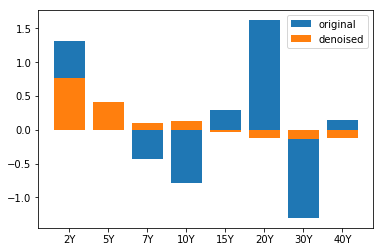

In [625]:
xs = np.arange(data.shape[1])
plt.bar(xs,optPort(cov).reshape(-1), tick_label = columns,label = 'original')
plt.bar(xs,optPort(denoised_cov).reshape(-1), tick_label = columns, label = 'denoised')
plt.legend()
plt.show()

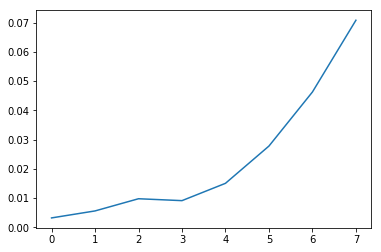

In [623]:
plt.plot(xs, np.diag(cov), label = 'variance',)

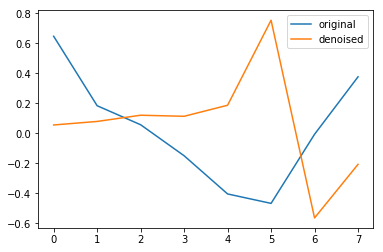

In [626]:
i = 2
plt.plot(eVec[:,i], label = 'original')
plt.plot(denoised_eVec[:, i], label = 'denoised')
plt.legend()
plt.show()

In [613]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)